# Inferencing output image by using pre-trained Model

In [155]:
import os, torch, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [157]:
# 체크포인트 경로 및 체크포인트 파일 확인
chk_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint'
chk_file = os.path.join(chk_dir, 'model_epoch.pth')

In [158]:
print(os.path.exists(chk_dir))
print(chk_dir)
print(chk_file)

True
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint/model_epoch.pth


## Create Dataset and Dataloader for TestModel.

## Create Test Model(with checkpoint file)

In [159]:
# https://pypi.org/project/segmentation-models-pytorch/
!pip install -q segmentation-models-pytorch
!pip install -q albumentations

In [160]:
import segmentation_models_pytorch as smp
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

In [ ]:
# define model and load pre-trained model.
model = smp.Unet(encoder_name="resnet18", encoder_weights=None, classes=4, activation=None)
dict_model = torch.load(f=chk_file, map_location=torch.device(device))  # keys for dict : 'net', 'optim'

model.load_state_dict(dict_model['net'])
model.eval()

데이터 셋을 만들기 전에 이미지 한 개로 모델 테스트를 해보자.

In [162]:
data_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/datasets'
data_test = os.path.join(data_dir, 'test_images')
fnames = os.listdir(data_test)

In [163]:
len(fnames)

5506

In [164]:
input = cv2.imread(os.path.join(data_test, fnames[99]))

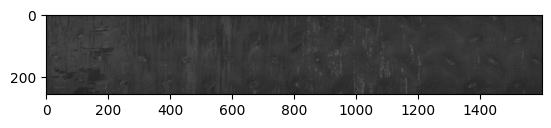

In [165]:
plt.imshow(input)

In [166]:
mean = (0.485, 0.456, 0.406)
std =  (0.229, 0.224, 0.225)
# transform function and apply it.
list_transforms = [Normalize(mean=mean, std=std, p=1), ToTensorV2()]
transforms = Compose(list_transforms)

In [167]:
input_t = transforms(image=input)
input_t = input_t['image']

if input_t.ndim == 3:
  input_t = input_t.unsqueeze(dim=0)
  print(input_t.shape)  # (batch_size, channel, width, height)

torch.Size([1, 3, 256, 1600])


In [168]:
output_t = model(input_t)
output_t = torch.sigmoid(output_t)

In [169]:
# make tensor to numpy
output_n = output_t.detach().cpu().numpy()

In [170]:
# I transformed output data into numpy-shape(n,w,h,c),
# but, in order to loop data by each channel, i do not need to transpose this array data.
# output_n = output_n.transpose(0,2,3,1)
output_n.shape

(1, 4, 256, 1600)

In [171]:
print(type(output_n))
print(output_n.max())

<class 'numpy.ndarray'>
0.14791058


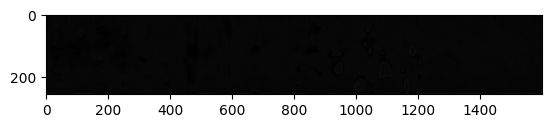

In [172]:
plt.imshow(output_n[0][0], cmap='gray')

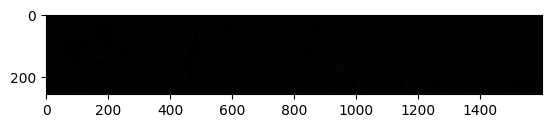

In [173]:
plt.imshow(output_n[0][1], cmap='gray')

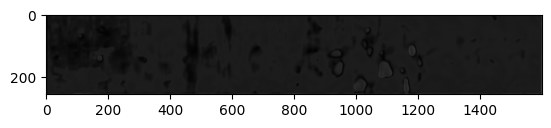

In [174]:
plt.imshow(output_n[0][2], cmap='gray')

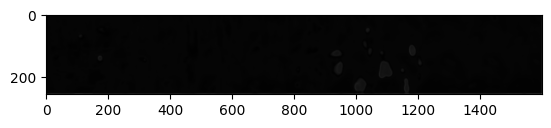

In [175]:
plt.imshow(output_n[0][3], cmap='gray')

(array([1.21367e+05, 2.85507e+05, 1.94100e+03, 5.32000e+02, 2.13000e+02,
        3.80000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.00835105, 0.022307  , 0.03626296, 0.05021891, 0.06417486,
        0.07813081, 0.09208677, 0.10604272, 0.11999867, 0.13395463,
        0.14791058]),
 <BarContainer object of 10 artists>)

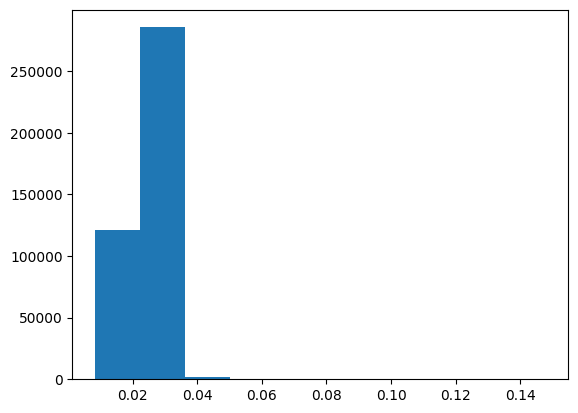

In [176]:
plt.hist(output_n[0][2].ravel())

In [177]:
fn_class = lambda x: (x>0.09) * 1
output_n_class = fn_class(output_n)

In [178]:
output_n_class[0][2].max()

1

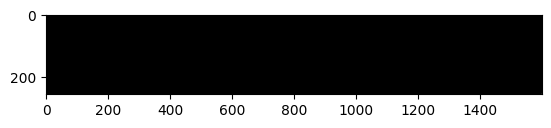

In [179]:
plt.imshow(output_n_class[0][2], cmap='gray')

## Mask to RLE

In [180]:
mask1 = output_n_class[0][0].T.flatten()
mask2 = output_n_class[0][1].T.flatten()
mask3 = output_n_class[0][2].T.flatten()
mask4 = output_n_class[0][3].T.flatten()

In [181]:
key, cnt = np.unique(mask3, return_counts=True)

In [182]:
dict(zip(key, cnt))

{0: 409598, 1: 2}

In [183]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [184]:
a_flat = a.flatten()
a_T_flat = a.T.flatten()

In [185]:
a_flat

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [186]:
a_T_flat

array([1, 4, 7, 2, 5, 8, 3, 6, 9])

T 를 사용한 후 flatten 을 걸어주는 이유를 여기서 확인할 수 있다. 행 방향 순서대로 요소를 하나씩 인덱싱 하는 방식(포트란)을 사용하기 때문에, transpose 를 먼저 수행 한 후 mask 작업을 해준다.

In [187]:
# np.concatenate 사용법
a = np.array([1,2,3,4,5])
a

array([1, 2, 3, 4, 5])

In [188]:
a = np.concatenate([[0],a,[9999]])
a

array([   0,    1,    2,    3,    4,    5, 9999])

In [189]:
# bit 연산을 이용? 해서 자릿수가 다른 위치를 찾아간다.
mask3 = np.concatenate([[0],mask3, [0]])

In [190]:
print(mask3[1:].shape)
mask3[1:]

(409601,)


array([0, 0, 0, ..., 0, 1, 0])

In [191]:
print(mask3[:-1].shape)
mask3[:-1]

(409601,)


array([0, 0, 0, ..., 0, 0, 1])

In [192]:
tmp = np.where(mask3[1:] != mask3[:-1])[0]
tmp

array([409344, 409345, 409599, 409600])

In [193]:
runs = tmp + 1
runs

array([409345, 409346, 409600, 409601])

In [194]:
# position index : starting
print(runs[::2])
# position index : ending, (reference for length value)
print(runs[1::2])

[409345 409600]
[409346 409601]


In [195]:
# get length value by subtraction
runs[1::2] = runs[1::2] - runs[::2]
print(runs)

[409345      1 409600      1]


check rle data with flatten array.

In [196]:
strtmp = ' '.join(str(run) for run in runs)
strtmp

'409345 1 409600 1'

Define as a function.

In [197]:
def mask2rle(img):
  mask = img.T.flatten()
  mask = np.concatenate([[0],mask,[0]])

  runs = np.where(mask[:-1]!=mask[1:])[0] + 1   # find the index of different digit between 0 and 1
  runs[1::2] = runs[1::2] - runs[:-1:2]         # update length value

  # make into string data.
  return ' '.join(str(run) for run in runs)

In [201]:
rle1 = mask2rle(mask1)
rle2 = mask2rle(mask2)
rle3 = mask2rle(mask3)
rle4 = mask2rle(mask4)

'409346 1 409601 1'